# Import dataset

In [17]:
# Import libraries

import os
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import sklearn.model_selection
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [2]:
# Set seed for reproducibility

seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

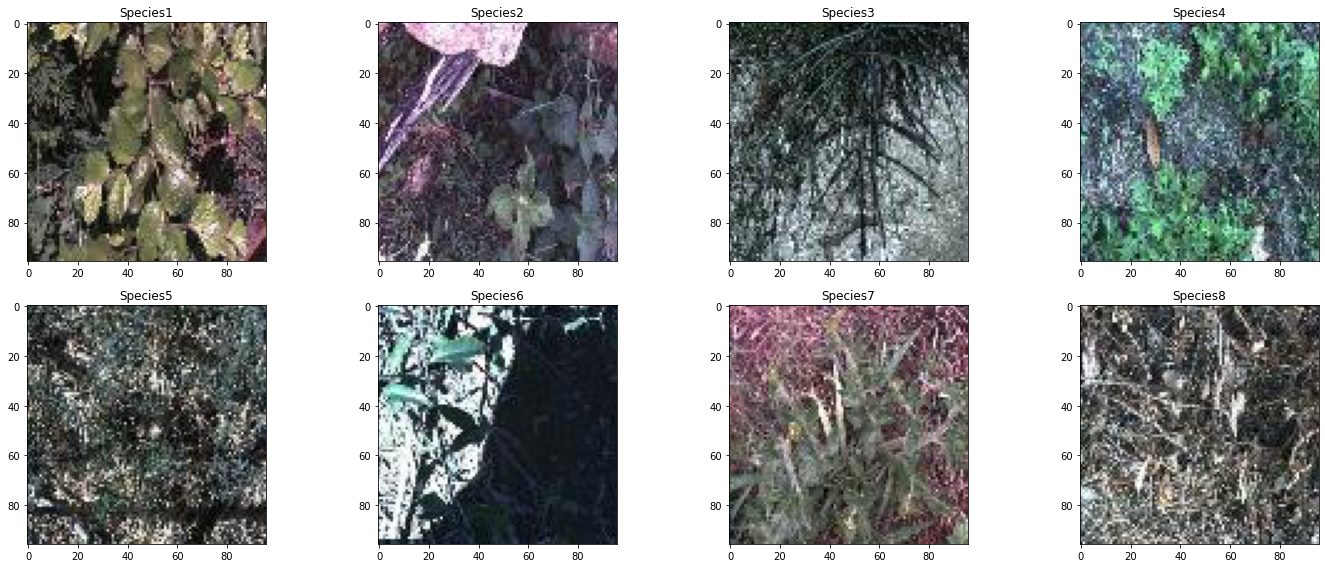

In [5]:
# Load the dataset

dataset_dir = '../input/training-dataset-homework1zip/training_data_final'

labels = ['Species1',       # 0
          'Species2',       # 1
          'Species3',       # 2
          'Species4',       # 3
          'Species5',       # 4
          'Species6',       # 5
          'Species7',       # 6
          'Species8']       # 7

# Show samples for each class

num_row = 2
num_col = 4
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
for i in range(num_row*num_col):
    if i < 8:
        class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
        class_img = class_imgs[0]
        img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
        ax = axes[i//num_col, i%num_col]
        ax.imshow(np.array(img))
        ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()


# Metadata

epochs = 200
batch_size = 16
input_shape = (96, 96, 3)

In [6]:
# Create an instance of ImageDataGenerator for training and validation sets

train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
valid_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_data_gen = train_data_gen.flow_from_directory(directory=dataset_dir, 
                                               target_size=(96, 96), 
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=batch_size, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=seed,
                                               subset = 'training')

valid_data_gen = valid_data_gen.flow_from_directory(directory=dataset_dir, 
                                           target_size=(96, 96), 
                                           color_mode='rgb',
                                           classes=None,
                                           batch_size=batch_size, 
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=seed,
                                           subset = 'validation')

Found 3191 images belonging to 8 classes.
Found 351 images belonging to 8 classes.


# CNN

In [7]:
# Define the model from scratch

def build_model(input_shape):
    
    l1_lambda = 0.002 #parameter for regularization
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    conv1 = tfkl.Conv2D(
        filters=32,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D()(conv1)

    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D()(conv2)

    conv3 = tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D()(conv3)

    conv4 = tfkl.Conv2D(
        filters=256,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D()(conv4)

    conv5 = tfkl.Conv2D(
        filters=512,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D()(conv5)
    
    gap_layer = tfkl.GlobalAveragePooling2D(name='Gap')(pool5)
    dropout = tfkl.Dropout(0.3, seed=seed)(gap_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', 
                                  kernel_initializer=tfk.initializers.HeUniform(seed), 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.L1L2(l1_lambda))(dropout)
    dropout = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=8, activation='softmax', 
                              kernel_initializer=tfk.initializers.HeUniform(seed), 
                              name='output_layer',
                              kernel_regularizer=tf.keras.regularizers.L1L2(l1_lambda))(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [8]:
# Build model

model = build_model(input_shape)
model.summary()

2022-11-26 17:18:05.823813: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 17:18:05.959679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 17:18:05.960531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 17:18:05.962268: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 128)       0     

In [9]:
# Train the model

history = model.fit(
    x = train_data_gen,
    epochs = epochs,
    validation_data = valid_data_gen,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
).history

Epoch 1/200


2022-11-26 17:18:08.626513: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-26 17:18:10.084747: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


200/200 [==============================] - 17s 51ms/step - loss: 13.4815 - accuracy: 0.2407 - val_loss: 5.0545 - val_accuracy: 0.2792
Epoch 2/200
200/200 [==============================] - 4s 22ms/step - loss: 3.4263 - accuracy: 0.3250 - val_loss: 2.4761 - val_accuracy: 0.2849
Epoch 3/200
200/200 [==============================] - 4s 21ms/step - loss: 2.1614 - accuracy: 0.3610 - val_loss: 1.8829 - val_accuracy: 0.4245
Epoch 4/200
200/200 [==============================] - 4s 22ms/step - loss: 1.8402 - accuracy: 0.4206 - val_loss: 1.6709 - val_accuracy: 0.4615
Epoch 5/200
200/200 [==============================] - 4s 21ms/step - loss: 1.7026 - accuracy: 0.4409 - val_loss: 1.6029 - val_accuracy: 0.4929
Epoch 6/200
200/200 [==============================] - 4s 21ms/step - loss: 1.6424 - accuracy: 0.4607 - val_loss: 1.6026 - val_accuracy: 0.4672
Epoch 7/200
200/200 [==============================] - 4s 22ms/step - loss: 1.5736 - accuracy: 0.4698 - val_loss: 1.6940 - val_accuracy: 0.3932
Ep

In [10]:
# Save best epoch model

model.save("SubmissionModel")

2022-11-26 17:22:20.891355: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [11]:
# Make a zip to download the model

shutil.make_archive("SubmissionModel", 'zip', "./SubmissionModel")

'/kaggle/working/SubmissionModel.zip'

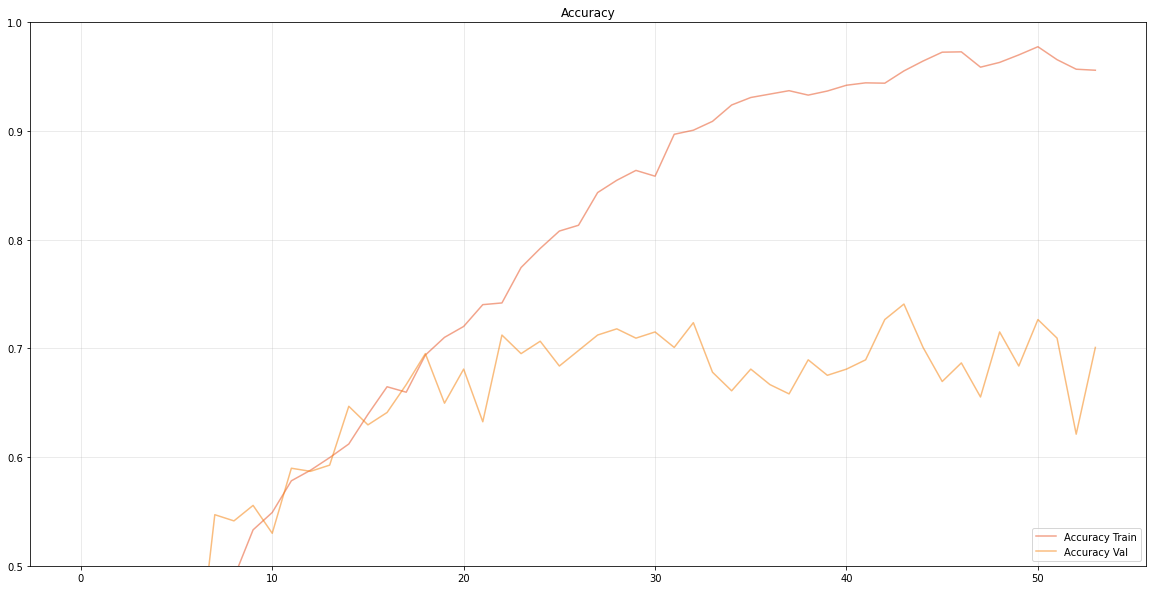

In [12]:
# Plot accuracy graph

plt.figure(figsize=(20,10))

ALPHA = 0.5
 
plt.plot(history['accuracy'], label='Accuracy Train', alpha=ALPHA, color='#E64A19') 
plt.plot(history['val_accuracy'], label='Accuracy Val', alpha=ALPHA, color='#F57C00') 
 
plt.ylim(.5, 1) 
plt.title('Accuracy') 
plt.legend(loc='lower right') 
plt.grid(alpha=.3) 
plt.show()

Accuracy: 0.7407
Precision: 0.7038
Recall: 0.6904
F1: 0.6938


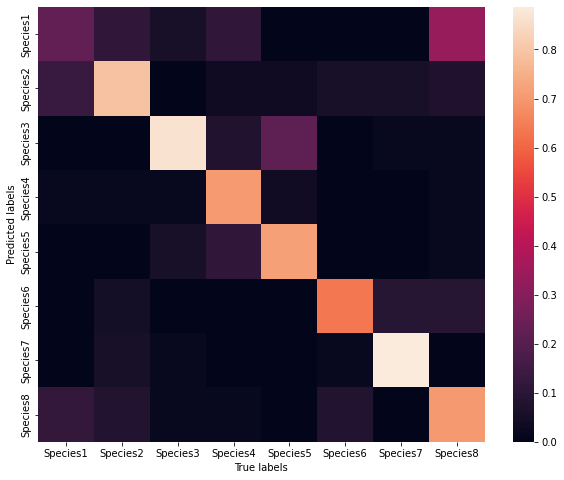

In [20]:
# Plot confusion matrix

# Predict the validation set
y_val = valid_data_gen.labels
predictions = model.predict(valid_data_gen)
predictions.shape

labels = {0:'Species1',       # 0
          1:'Species2',       # 1
          2:'Species3',       # 2
          3:'Species4',       # 3
          4:'Species5',       # 4
          5:'Species6',       # 5
          6:'Species7',       # 6
          7:'Species8'}       # 7

# Compute the confusion matrix
cm = confusion_matrix(y_val, np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(y_val, np.argmax(predictions, axis=-1))
precision = precision_score(y_val, np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(y_val, np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(y_val, np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

cm = cm /cm.astype(float).sum(axis=1);

# Plot
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [18]:
# Print some statistics

print( classification_report(y_val, np.argmax(predictions, axis=-1)) )

              precision    recall  f1-score   support

           0       0.27      0.22      0.24        18
           1       0.67      0.79      0.72        53
           2       0.72      0.86      0.79        51
           3       0.86      0.71      0.77        51
           4       0.79      0.72      0.75        53
           5       0.74      0.64      0.68        22
           6       0.90      0.89      0.90        53
           7       0.69      0.70      0.69        50

    accuracy                           0.74       351
   macro avg       0.70      0.69      0.69       351
weighted avg       0.74      0.74      0.74       351



# K-fold

In [14]:
# Get a dataframe of the dataset

species_dir = os.path.join(dataset_dir,labels[0])
allfiles = np.array(os.listdir(species_dir))
allfiles = np.sort(allfiles)
allfiles = np.array(list(map(lambda x : labels[0]+x, allfiles)))
imgs = allfiles
classes = labels[0]
for i in range (1, np.size(imgs)):
    classes = np.append(classes, labels[0])

for i in range (1,8):
    species_dir = os.path.join(dataset_dir,labels[i])
    allfiles = np.array(os.listdir(species_dir))
    allfiles = np.sort(allfiles)
    allfiles = np.array(list(map(lambda x : labels[i]+x, allfiles)))
    imgs = np.append(imgs, allfiles)
    for j in range (0, np.size(allfiles)):
        classes = np.append(classes, labels[i])

imgs.astype('object')
classes.astype('object')        
data = {'Image': imgs,
        'Class': classes
        }
df = pd.DataFrame(data)
print(df)

y_train_val = df.Class
X_train_val = df.drop(['Class'],axis=1)

                  Image     Class
0     Species100000.jpg  Species1
1     Species100001.jpg  Species1
2     Species100002.jpg  Species1
3     Species100003.jpg  Species1
4     Species100004.jpg  Species1
...                 ...       ...
3537  Species800503.jpg  Species8
3538  Species800504.jpg  Species8
3539  Species800505.jpg  Species8
3540  Species800506.jpg  Species8
3541  Species800507.jpg  Species8

[3542 rows x 2 columns]


In [15]:
# Create a folder with all the images together to succesively perform k-fold cross validation

dst_dir = './allSpeciesImages'
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
    
    for i in range (0,8):
        species_dir = os.path.join(dataset_dir,labels[i])
        allfiles = np.array(os.listdir(species_dir))
        allfiles = np.sort(allfiles)
        for f in allfiles:
            src_path = os.path.join(species_dir,f)
            new_name = labels[i]+f
            dst_path = os.path.join(dst_dir,new_name)
            shutil.copyfile(src_path, dst_path)    

In [21]:
# K-fold to estimate the skill of the model

num_folds = 10

image_generator = ImageDataGenerator(rescale=1/255., validation_split=0.1)
train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()

validation_accuracy = []
validation_dataset = []
histories = []

kfold = sklearn.model_selection.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

j = 0

# K-fold Train for each split
for train_idx, val_idx in list(kfold.split(X_train_val,y_train_val)):
    
    print("\nStarting training on fold num: {}".format(j+1))
    x_train_df = df.iloc[train_idx]
    x_valid_df = df.iloc[val_idx]
    
    train_data_gen = image_generator.flow_from_dataframe(dataframe=x_train_df, 
                                                         directory=dst_dir,
                                                         x_col="Image", 
                                                         y_col="Class",
                                                         classes=None, 
                                                         class_mode="categorical",
                                                         target_size=(96,96), 
                                                         color_mode='rgb',
                                                         shuffle=True,
                                                         seed=seed,
                                                         batch_size=batch_size)

    valid_data_gen = image_generator.flow_from_dataframe(dataframe=x_valid_df, 
                                                         directory=dst_dir,
                                                         x_col="Image", 
                                                         y_col="Class",
                                                         classes=None, 
                                                         class_mode="categorical",
                                                         target_size=(96,96), 
                                                         color_mode='rgb',
                                                         shuffle=False,
                                                         seed=seed,
                                                         batch_size=batch_size)

    # Compile the model
    model = build_model(input_shape)
    
    # Train the model
    history = model.fit( train_data_gen,
                         validation_data=valid_data_gen,
                         epochs = epochs,
                         verbose = 1,
                         callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                                    mode='max', 
                                                                    patience=10, 
                                                                    restore_best_weights=True)
                       ).history
    
    pathModel = "./kfoldModel/model_"+str(j)
    model.save(pathModel)

    validation_accuracy.append(np.max(history['val_accuracy']))
    validation_dataset.append(valid_data_gen)
    histories.append(history)

    j+=1


Starting training on fold num: 1
Found 3187 validated image filenames belonging to 8 classes.
Found 355 validated image filenames belonging to 8 classes.
Epoch 1/200
200/200 [==============================] - 4s 16ms/step - loss: 12.5888 - accuracy: 0.2736 - val_loss: 4.0303 - val_accuracy: 0.4310
Epoch 2/200
200/200 [==============================] - 3s 14ms/step - loss: 2.8466 - accuracy: 0.3671 - val_loss: 2.1490 - val_accuracy: 0.3521
Epoch 3/200
200/200 [==============================] - 3s 14ms/step - loss: 1.9810 - accuracy: 0.3897 - val_loss: 1.9120 - val_accuracy: 0.3944
Epoch 4/200
200/200 [==============================] - 3s 15ms/step - loss: 1.7660 - accuracy: 0.4415 - val_loss: 1.6942 - val_accuracy: 0.4535
Epoch 5/200
200/200 [==============================] - 3s 16ms/step - loss: 1.6855 - accuracy: 0.4462 - val_loss: 1.6307 - val_accuracy: 0.4310
Epoch 6/200
200/200 [==============================] - 3s 13ms/step - loss: 1.5905 - accuracy: 0.4716 - val_loss: 1.5183 - v

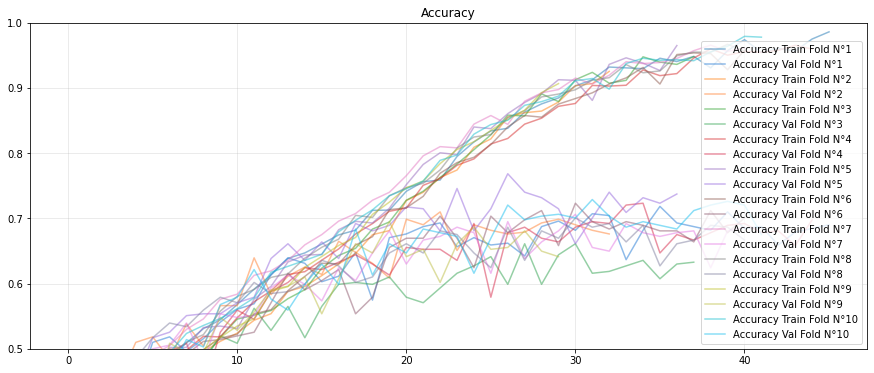

In [22]:
# Plot accuracy graph

ALPHA = 0.5
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
colors2 = ['#1f77d4', '#ff7f2e', '#2ca04c', '#d62748', '#9467dd', '#8c566b', '#e377e2', '#7f7f9f', '#bcbd42', '#17beef']

plt.figure(figsize=(15,6))
for fold_idx in range(num_folds):
    plt.plot(histories[fold_idx]['accuracy'], label='Accuracy Train Fold N°{}'.format(fold_idx+1), 
             alpha=ALPHA, color=colors[fold_idx]) 
    plt.plot(histories[fold_idx]['val_accuracy'], label='Accuracy Val Fold N°{}'.format(fold_idx+1), 
             alpha=ALPHA, color=colors2[fold_idx]) 
    
    plt.ylim(.5, 1) 
    plt.title('Accuracy') 
    plt.legend(loc='lower right') 
    plt.grid(alpha=.3) 
plt.show()